In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
def faststem(x, y, *args, **kwargs):
    ord = np.argsort(x)
    x = x[ord]
    y = y[ord]
    x = np.array([x,x,x]).T.ravel()
    y = np.array([0*y,y,np.nan*y]).T.ravel()
    plt.gca().plot(x,y,*args,**kwargs)

In [3]:
from src.datamodule import MSDataModule
from src.model import MSTransformer
from src.constants import MSConstants
C = MSConstants()

In [4]:
dm = MSDataModule(
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=32,
    train_val_split=0.95,
    cdhit_threshold=0.95,
    cdhit_word_length=5,
    cache_dir='$TMPDIR',
    num_workers=4
)

In [5]:
!ssh login-2 'tmux kill-session -t tensorboard; tmux new-session -s tensorboard -d srun --resv-ports=1 --pty bash -i -c "~/TensorBoard.sh ~/MSPretraining/lightning_logs"'


In [6]:
model = MSTransformer(
    residues=C.alphabet,
    ions=C.ions,
    parent_min_charge=C.min_charge,
    parent_max_charge=C.max_charge,
    fragment_min_charge=C.min_frag_charge,
    fragment_max_charge=C.max_frag_charge,
    losses=C.losses,
    model_dim=512,
    model_depth=4,
    num_heads=8,
    lr=1e-5,
    dropout=0.1, 
    max_length=100
)

In [7]:
from pytorch_lightning import Trainer

trainer = Trainer(
    gpus=1,
    num_sanity_val_steps=0,
    max_epochs=1,
    log_every_n_steps=1
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-42ce0213-d4cd-d418-0188-8a9184079632]
Set SLURM handle signals.

  | Name                | Type               | Params
-----------------------------------------------------------
0 | residue_embedding   | Embedding          | 12.3 K
1 | charge_embedding    | Embedding          | 3.1 K 
2 | ce_embedding        | Linear             | 1.0 K 
3 | positional_encoding | PositionalEncoding | 0     
4 | transformer         | Transformer        | 16.8 M
5 | classifier          | Linear             | 9.2 K 
-----------------------------------------------------------
16.9 M    Trainable params
0         Non-trainable params
16.9 M    Total params
67.433    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/gridsan/mmurphy/.conda/envs/NileRed/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [37]:
for batch in dm.train_dataloader():
    break
    
model = model.cpu()
batch['y_pred'] = model.predict_step(batch)

# why the hell isn't the charge embedding working

# why the hell is loss zero

In [43]:
from torch.nn import functional as F
batch_size = batch['x'].shape[0]
y_total = batch['y'].flatten(1).sum(1).view(batch_size,1,1,1,1)
model.masked_loss(F.cross_entropy, batch['y_pred'], batch['y'] / y_total, batch['y_mask'].bool())


tensor(0., grad_fn=<DivBackward0>)

In [46]:
# batch['y_mask'].bool().sum()
(batch['y'] / y_total).sum()

tensor(32.)

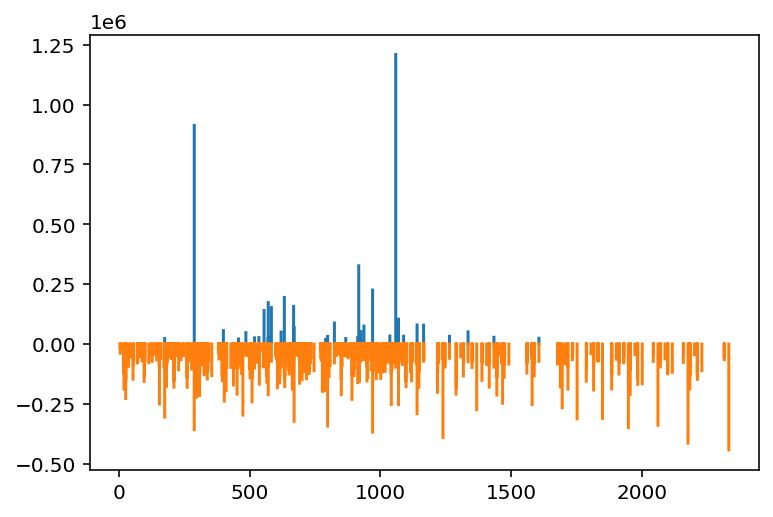

In [38]:
from src.spectrum import fragment_mz_tensor
mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
y = batch['y'][0].detach().cpu().numpy().ravel()
y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
faststem(mz,y)
faststem(mz,-y_pred)